# <a href="http://www.datascience-paris-saclay.fr">Paris Saclay Center for Data Science</a>
# <a href=https://www.ramp.studio/problems/air_passengers>RAMP</a> on predicting the number of air passengers

<i> Balázs Kégl (LAL/CNRS), Alex Gramfort (LTCI/Telecom ParisTech), Djalel Benbouzid (UPMC), Mehdi Cherti (LAL/CNRS) </i>

## Introduction
The data set was donated to us by an unnamed company handling flight ticket reservations. The data is thin, it contains
<ul>
<li> the date of departure
<li> the departure airport
<li> the arrival airport
<li> the mean and standard deviation of the number of weeks of the reservations made before the departure date
<li> a field called <code>log_PAX</code> which is related to the number of passengers (the actual number were changed for privacy reasons)
</ul>

The goal is to predict the <code>log_PAX</code> column. The prediction quality is measured by RMSE. 

The data is obviously limited, but since data and location informations are available, it can be joined to external data sets. <b>The challenge in this RAMP is to find good data that can be correlated to flight traffic</b>.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

In [2]:
# !pip install -U seaborn  # if you don't have it, or pip3 for python3

In [3]:
# optional
import seaborn as sns; sns.set()

## Fetch the data and load it in pandas

In [4]:
data = pd.read_csv("data/train.csv.bz2")

In [5]:
print(min(data['DateOfDeparture']))
print(max(data['DateOfDeparture']))

2011-09-01
2013-03-05


In [6]:
data.head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,log_PAX,std_wtd
0,2012-06-19,ORD,DFW,12.875000,12.331296,9.812647
1,2012-09-10,LAS,DEN,14.285714,10.775182,9.466734
2,2012-10-05,DEN,LAX,10.863636,11.083177,9.035883
3,2011-10-09,ATL,ORD,11.480000,11.169268,7.990202
4,2012-02-21,DEN,SFO,11.450000,11.269364,9.517159


In [7]:
data['Departure'].unique()

array(['ORD', 'LAS', 'DEN', 'ATL', 'SFO', 'EWR', 'IAH', 'LAX', 'DFW',
       'SEA', 'JFK', 'PHL', 'MIA', 'DTW', 'BOS', 'MSP', 'CLT', 'MCO',
       'PHX', 'LGA'], dtype=object)

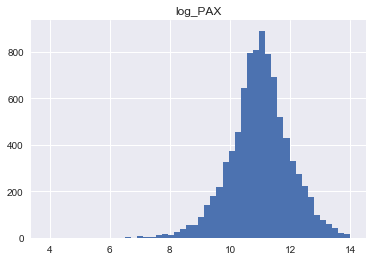

In [8]:
data.hist(column='log_PAX', bins=50);

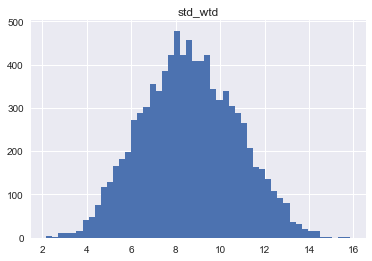

In [9]:
data.hist('std_wtd', bins=50);

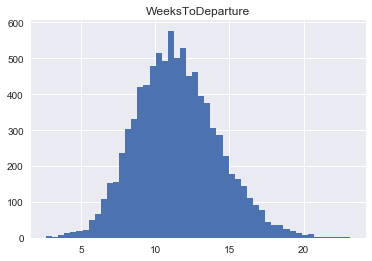

In [10]:
data.hist('WeeksToDeparture', bins=50);

In [11]:
data.describe()

,WeeksToDeparture,log_PAX,std_wtd
count,8902.000000,8902.000000,8902.000000
mean,11.446469,10.999048,8.617773
std,2.787140,0.993945,2.139604
min,2.625000,3.878108,2.160247
25%,9.523810,10.427055,7.089538
50%,11.300000,11.013357,8.571116
75%,13.240000,11.592888,10.140521
max,23.163265,14.007791,15.862216


In [12]:
data.dtypes

DateOfDeparture      object
Departure            object
Arrival              object
WeeksToDeparture    float64
log_PAX             float64
std_wtd             float64
dtype: object

In [13]:
data.shape

(8902, 6)

In [14]:
print(data['log_PAX'].mean())
print(data['log_PAX'].std())

10.999047672120955
0.9939452411746512


## Preprocessing for prediction

Getting dates into numerical columns is a common operation when time series are analyzed with non-parametric predictors. The code below makes all possible choices: ordered columns for the year, month, day, weekday, week, and day in the year, and one-hot columns for year month, day, weekday, and week.

The departure and arrival airports are also converted into one-hot columns. 

In [15]:
data_encoded = data

data_encoded = data_encoded.join(pd.get_dummies(data_encoded['Departure'], prefix='d'))
data_encoded = data_encoded.join(pd.get_dummies(data_encoded['Arrival'], prefix='a'))
data_encoded = data_encoded.drop('Departure', axis=1)
data_encoded = data_encoded.drop('Arrival', axis=1)

# following http://stackoverflow.com/questions/16453644/regression-with-date-variable-using-scikit-learn
data_encoded['DateOfDeparture'] = pd.to_datetime(data_encoded['DateOfDeparture'])
data_encoded['year'] = data_encoded['DateOfDeparture'].dt.year
data_encoded['month'] = data_encoded['DateOfDeparture'].dt.month
data_encoded['day'] = data_encoded['DateOfDeparture'].dt.day
data_encoded['weekday'] = data_encoded['DateOfDeparture'].dt.weekday
data_encoded['week'] = data_encoded['DateOfDeparture'].dt.week
data_encoded['n_days'] = data_encoded['DateOfDeparture'].apply(lambda date: (date - pd.to_datetime("1970-01-01")).days)

data_encoded = data_encoded.join(pd.get_dummies(data_encoded['year'], prefix='y'))
data_encoded = data_encoded.join(pd.get_dummies(data_encoded['month'], prefix='m'))
data_encoded = data_encoded.join(pd.get_dummies(data_encoded['day'], prefix='d'))
data_encoded = data_encoded.join(pd.get_dummies(data_encoded['weekday'], prefix='wd'))
data_encoded = data_encoded.join(pd.get_dummies(data_encoded['week'], prefix='w'))

In [16]:
data_encoded.tail(5)

,DateOfDeparture,WeeksToDeparture,log_PAX,std_wtd,d_ATL,d_BOS,d_CLT,d_DEN,d_DFW,d_DTW,d_EWR,d_IAH,d_JFK,d_LAS,d_LAX,d_LGA,d_MCO,d_MIA,d_MSP,d_ORD,d_PHL,d_PHX,d_SEA,d_SFO,a_ATL,a_BOS,a_CLT,a_DEN,a_DFW,a_DTW,a_EWR,a_IAH,a_JFK,a_LAS,a_LAX,a_LGA,a_MCO,a_MIA,a_MSP,a_ORD,a_PHL,a_PHX,a_SEA,a_SFO,year,month,day,weekday,week,n_days,y_2011,y_2012,y_2013,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,wd_0,wd_1,wd_2,wd_3,wd_4,wd_5,wd_6,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,w_10,w_11,w_12,w_13,w_14,w_15,w_16,w_17,w_18,w_19,w_20,w_21,w_22,w_23,w_24,w_25,w_26,w_27,w_28,w_29,w_30,w_31,w_32,w_33,w_34,w_35,w_36,w_37,w_38,w_39,w_40,w_41,w_42,w_43,w_44,w_45,w_46,w_47,w_48,w_49,w_50,w_51,w_52
8897,2011-10-02,9.263158,10.427055,7.316967,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011,10,2,6,39,15249,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
8898,2012-09-25,12.772727,12.201552,10.641034,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2012,9,25,1,39,15608,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
8899,2012-01-19,11.047619,10.508746,7.908705,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2012,1,19,3,3,15358,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8900,2013-02-03,6.076923,10.174042,4.030334,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2013,2,3,6,5,15739,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8901,2011-11-26,9.526316,9.202674,6.167733,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011,11,26,5,47,15304,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


### A linear regressor baseline

We drop the target column and the original data column.

In [17]:
features = data_encoded.drop(['log_PAX','DateOfDeparture'], axis=1)
X_columns = data_encoded.columns.drop(['log_PAX','DateOfDeparture'])
X = features.values
y = data_encoded['log_PAX'].values

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

It gives us a pretty nice improvement above baseline

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

reg = LinearRegression()

scores = cross_val_score(reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("log RMSE: {:.4f} +/-{:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

log RMSE: 0.6298 +/-0.0059


Exercise: Visualize the coefficients, try to make sense of them.

## Random Forests

In [20]:
%%time
from sklearn.ensemble import RandomForestRegressor

n_estimators = 10
max_depth = 10
max_features = 10
reg = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features)

scores = cross_val_score(reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error',n_jobs=3)
print("log RMSE: {:.4f} +/-{:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

log RMSE: 0.7563 +/-0.0281
CPU times: user 165 ms, sys: 69.9 ms, total: 235 ms
Wall time: 535 ms


## Variable importances

In [21]:
reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features=10, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [22]:
len(X_columns)

153

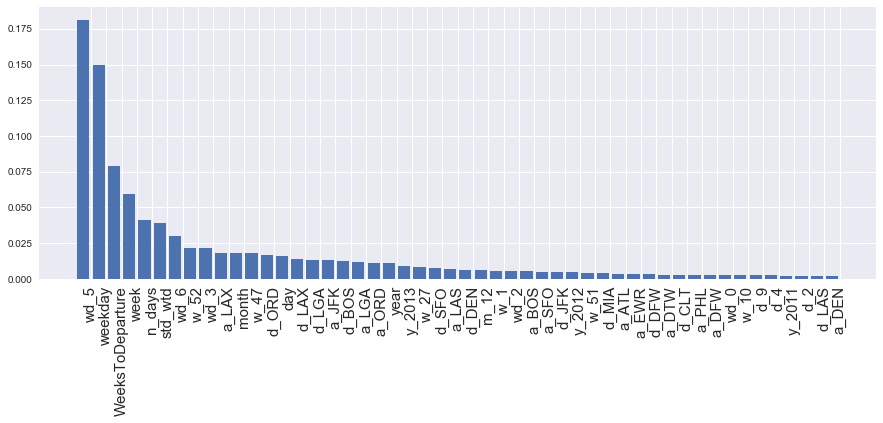

In [23]:
plt.figure(figsize=(15, 5))

ordering = np.argsort(reg.feature_importances_)[::-1][:50]

importances = reg.feature_importances_[ordering]
feature_names = X_columns[ordering]

x = np.arange(len(feature_names))
plt.bar(x, importances)
plt.xticks(x + 0.5, feature_names, rotation=90, fontsize=15);

## Building predictive models

### The feature extractor

The feature extractor implements a single <code>transform</code> function. It receives the full pandas object X_df (without the labels). It should produce a numpy array representing the features extracted. If you want to use the (training) labels to save some state of the feature extractor, you can do it in the fit function.

The starting kit feature extractor shows you how to join your data to external data. You will have the possibility to submit a single external csv for each of your submission (so if you have several data sets, you first have to do the join offline, and save it as a csv). In this case it is whether data, joined to the database on the <code>DateOfDeparture</code> and <code>Arrival</code> fields. Attention: when you join the data, make sure that the <b><font color=red>order</font> of the rows in the data frame does not change</b>.

The following cell is *not* executed in the notebook, rather it saves its content in the file in the first line, so you can edit your submission before running the local test below and submitting it at the RAMP site.

In [24]:
%%file submissions/starting_kit/feature_extractor.py
import pandas as pd
import os


class FeatureExtractor(object):
    def __init__(self):
        pass

    def fit(self, X_df, y_array):
        pass

    def transform(self, X_df):
        X_encoded = X_df
        path = os.path.dirname(__file__)
        data_weather = pd.read_csv(os.path.join(path, 'external_data.csv'))
        X_weather = data_weather[['Date', 'AirPort', 'Max TemperatureC']]
        X_weather = X_weather.rename(
            columns={'Date': 'DateOfDeparture', 'AirPort': 'Arrival'})
        X_encoded = pd.merge(
            X_encoded, X_weather, how='left',
            left_on=['DateOfDeparture', 'Arrival'],
            right_on=['DateOfDeparture', 'Arrival'],
            sort=False)

        X_encoded = X_encoded.join(pd.get_dummies(
            X_encoded['Departure'], prefix='d'))
        X_encoded = X_encoded.join(
            pd.get_dummies(X_encoded['Arrival'], prefix='a'))
        X_encoded = X_encoded.drop('Departure', axis=1)
        X_encoded = X_encoded.drop('Arrival', axis=1)

        X_encoded = X_encoded.drop('DateOfDeparture', axis=1)
        X_array = X_encoded.values
        return X_array



Overwriting submissions/starting_kit/feature_extractor.py


### The regressor

The regressor should implement an sklearn-like regressor with fit and predict functions.

In [25]:
%%file submissions/starting_kit/regressor.py
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator


class Regressor(BaseEstimator):
    def __init__(self):
        self.clf = RandomForestRegressor(
            n_estimators=10, max_depth=10, max_features=10)

    def fit(self, X, y):
        self.clf.fit(X, y)

    def predict(self, X):
        return self.clf.predict(X)



Overwriting submissions/starting_kit/regressor.py


## Local testing (before submission)

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. For this we provide a unit test. Note that the test runs on your files in [`submissions/starting_kit`](http://localhost:8890/tree/submissions/starting_kit).

First `pip install ramp-workflow` or install it from the [github repo](https://github.com/paris-saclay-cds/ramp-workflow). Make sure that the python files `feature_extractor.py`, `regressor.py`, and `external_data.csv` are in the  [`submissions/starting_kit`](http://localhost:8890/tree/submissions/starting_kit) folder, and the data `train.csv.bz2` and `test.csv.bz2` are in [`data`](http://localhost:8890/tree/data). Then run

```ramp_test_submission```

If it runs and print training and test errors on each fold, then you can submit the code.

In [26]:
!ramp_test_submission

Testing Number of air passengers prediction
Reading train and test files from ./data ...
Reading cv ...
Training ./submissions/starting_kit ...
CV fold 0
	score   rmse
	train  0.751
	valid  0.861
	test   0.874
CV fold 1
	score   rmse
	train  0.752
	valid  0.856
	test   0.871
CV fold 2
	score   rmse
	train  0.747
	valid  0.850
	test   0.879
CV fold 3
	score   rmse
	train  0.731
	valid  0.872
	test   0.871
CV fold 4
	score   rmse
	train  0.758
	valid  0.869
	test   0.883
CV fold 5
	score   rmse
	train  0.746
	valid  0.838
	test   0.874
CV fold 6
	score   rmse
	train  0.738
	valid  0.847
	test   0.877
CV fold 7
	score   rmse
	train  0.748
	valid  0.839
	test   0.877
----------------------------
Mean CV scores
----------------------------
	score            rmse
	train  0.746 ± 0.0079
	valid   0.854 ± 0.012
	test   0.876 ± 0.0039
----------------------------
Bagged scores
----------------------------
	score   rmse
	valid  0.839
	test   0.860


Alternatively, load and execute `rampwf.utils.testing.py`, and call `assert_submission`. This may be useful if you would like to understand how we instantiate the workflow, the scores, the data connectors, and the cross validation scheme defined in [`problem.py`](problem.py), and how we insert and train/test your submission.

In [27]:
# %load https://raw.githubusercontent.com/paris-saclay-cds/ramp-workflow/master/rampwf/utils/testing.py

In [28]:
# assert_submission()

## Submitting to [ramp.studio](http://ramp.studio)

Once you found a good model, you can submit it to [ramp.studio](http://www.ramp.studio). First, if it is your first time using RAMP, [sign up](http://www.ramp.studio/sign_up), otherwise [log in](http://www.ramp.studio/login). Then find an open event on the particular problem, for example, the event [DSSP 6](https://www.ramp.studio/events/air_passengers_dssp6) for this RAMP. Sign up for the event. Both signups are controled by RAMP administrators, so there **can be a delay between asking for signup and being able to submit**.

Once your signup request is accepted, you can go to your [sandbox](http://www.ramp.studio/events/air_passengers_dssp6/sandbox) and copy-paste (or upload) [`feature_extractor.py`](http://localhost:8890/edit/submissions/starting_kit/feature_extractor.py), [`regressor.py`](http://localhost:8890/edit/submissions/starting_kit/regressor.py), and [`external_data.csv`](http://localhost:8890/edit/submissions/starting_kit/external_data.csv) from `submissions/starting_kit`. Save it, rename it, then submit it. The submission is trained and tested on our backend in the same way as `ramp_test_submission` does it locally. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in [my submissions](http://www.ramp.studio/events/air_passengers_dssp6/my_submissions). Once it is trained, you get a mail, and your submission shows up on the [public leaderboard](http://www.ramp.studio/events/air_passengers_dssp6/leaderboard). 
If there is an error (despite having tested your submission locally with `ramp_test_submission`), it will show up in the "Failed submissions" table in [my submissions](http://www.ramp.studio/events/air_passengers_dssp6/my_submissions). You can click on the error to see part of the trace.

After submission, do not forget to give credits to the previous submissions you reused or integrated into your submission.

The data set we use at the backend is usually different from what you find in the starting kit, so the score may be different.

The usual way to work with RAMP is to explore solutions, add feature transformations, select models, perhaps do some AutoML/hyperopt, etc., _locally_, and checking them with `ramp_test_submission`. The script prints mean cross-validation scores 
```
----------------------------
train rmse = 0.748 ± 0.0117
valid rmse = 0.858 ± 0.0111
test rmse = 0.881 ± 0.005
```
The official score in this RAMP (the first score column after "historical contributivity" on the [leaderboard](http://www.ramp.studio/events/air_passengers_dssp6/leaderboard)) is root mean squared error ("rmse"), so the line that is relevant in the output of `ramp_test_submission` is `valid rmse = 0.858 ± 0.0111`. When the score is good enough, you can submit it at the RAMP.

## More information

You can find more information in the [README](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/README.md) of the [ramp-workflow library](https://github.com/paris-saclay-cds/ramp-workflow).

## Contact

Don't hesitate to [contact us](mailto:admin@ramp.studio?subject=air passengers notebook).